`Course Instructor`: **John Chiasson**

`Author (TA)`: **Ruthvik Vaila**

# Notes:
* In this notebook we shall load a large `NumPy` array directly into RAM to train a model.
* While the model is training keep an eye on the time taken and RAM usage of your machine.
* Tested on `Python 3.7.5` with `Tensorflow 1.15.0` and `Keras 2.2.4`. 
* Tested on `Python 2.7.17` with `Tensorflow 1.15.3` and `Keras 2.2.4`. 

# Imports

In [1]:
import sys, os
sys.version

'3.7.5 (default, Nov  7 2019, 10:50:52) \n[GCC 8.3.0]'

In [2]:
from tensorflow.compat.v1 import InteractiveSession
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"]="0" #setting it to -1 hides the GPU.
#tf.compat.v1.enable_eager_execution()
from tensorflow.python.client import device_lib
import numpy as np
import IPython
import sys, pickle, os, gzip
#import h5py, time
import IPython.display as display
from keras.utils import to_categorical
import keras, warnings
import matplotlib.pyplot as plt
import feature_reconstruction as fs
warnings.filterwarnings(action='once')
# GPU specific settings
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
session = InteractiveSession(config=config)
# this make sure that if using a gpu total gpu memory is not gobbled
# up by tensorflow and allows growth as required
##https://github.com/tensorflow/tensorflow/issues/24828

Using TensorFlow backend.
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-dgkhnb90 because the default path (/home/visionteam/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9517107407947471394,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12389371648091663295
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17664850190067440011
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7110747751
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15805517368584217625
 physical_device_desc: "device: 0, name: GeForce RTX 2080 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [4]:
print('TF version:{}, Keras version:{}'.format(tf.__version__, keras.__version__))

TF version:1.15.0, Keras version:2.2.4


# Load the data
* There are `60000` images in the training set and each image needs to be of size `(28, 28, 1)` for `Keras`. The extra dimension in `(28, 28, 1)` indicates number of channels. In this case we have `1` channel because it's a gray scale image. In datasets like `CIFAR-10`, `CIFAR-100`, and `ImageNet` images have `3` channels `(RGB)`. 

In [5]:
filename = 'data/mnist.pkl.gz'
filehandle = gzip.open(filename, 'rb')
train_data, val_data, test_data = pickle.load(filehandle, encoding='latin1')
#train_data, val_data, test_data = pickle.load(filehandle)
filehandle.close()
train_x, train_y = train_data
print('train_x.shape:{} and train_y.shape:{}'.format(train_x.shape, train_y.shape))
val_x, val_y = val_data
print('val_x.shape:{} and val_y.shape:{}'.format(val_x.shape, val_y.shape))
print('images are 28*28 = 784 vectors')
#print(train_x[0]) # images are float32, normalized, and 784 vectors
print('')
# combine train and validation data as Keras will split it internally
train_x = np.concatenate([train_x, val_x], axis=0)
train_y = np.concatenate([train_y, val_y], axis=0)
print('train_x.shape:{}'.format(train_x.shape))
print('train_y.shape:{}'.format(train_y.shape))
print('')
print('train_x[0].shape:{}'.format(train_x.shape[0]))
print('train_x[1].shape:{}'.format(train_x.shape[1]))
print('')
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1)
print('train_x.shape:{}'.format(train_x.shape))
print('train_y.shape:{}'.format(train_y.shape))
print('train_x[59999].shape: {}'.format(train_x[59999].shape))
#print('train_x[0]: {}'.format(train_x[0]))
print('')
test_x, test_y = test_data
print('test_x.shape:{}'.format(test_x.shape))
test_x = test_x.reshape(test_x.shape[0], 28, 28, 1)
print('test_x.shape:{}'.format(test_x.shape))
print('test_y.shape:{}'.format(test_y.shape))
#train_x.shape[0]


train_x.shape:(50000, 784) and train_y.shape:(50000,)
val_x.shape:(10000, 784) and val_y.shape:(10000,)
images are 28*28 = 784 vectors

train_x.shape:(60000, 784)
train_y.shape:(60000,)

train_x[0].shape:60000
train_x[1].shape:784

train_x.shape:(60000, 28, 28, 1)
train_y.shape:(60000,)
train_x[59999].shape: (28, 28, 1)

test_x.shape:(10000, 784)
test_x.shape:(10000, 28, 28, 1)
test_y.shape:(10000,)


## One hot vectorize labels

In [6]:
train_y = to_categorical(train_y)
print('train_y.shape:{}'.format(train_y.shape))

test_y = to_categorical(test_y)
print('test_y.shape:{}'.format(test_y.shape))
train_y[0]

train_y.shape:(60000, 10)
test_y.shape:(10000, 10)


array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

## Visualize the dataset.
* The toggle command `ctrl + /` comments/uncomments multiple lines of code

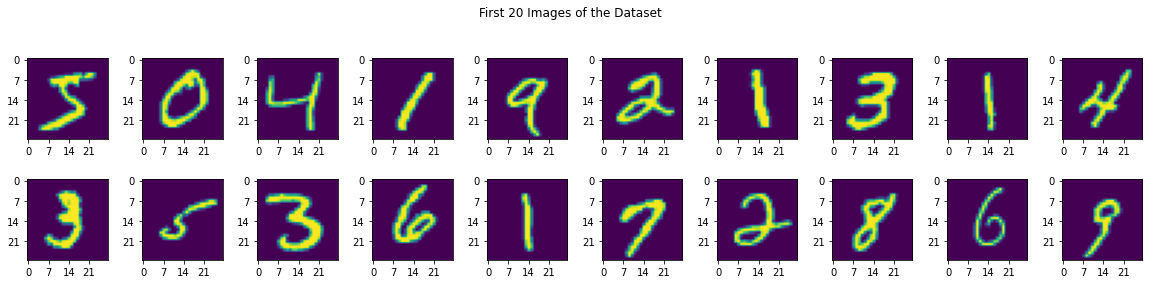

In [7]:
fig, axes = plt.subplots(2, 10, figsize=(20,4), subplot_kw={'xticks': range(0,28,7), 'yticks': range(0,28,7)})
fig.subplots_adjust(left=0.12, bottom=0.1, right=0.9, top=0.8, wspace=0.3, hspace=0.5)
#axes is a 2 by 10 array of the memory addresses of the subplots
#print(axes)
axes = axes.flatten()  #  axes is now a 1 by 20 array of the memory addresses of the subplots
#print(fig.shape)
#print(len(axes))
for i in range(len(axes)):
    axes[i].imshow(train_x[i,:,:,0])
plt.suptitle('First 20 Images of the Dataset')
plt.show()

#### Setup a small CNN model using `tf.keras.Sequential` 
* A simple convolutional neural network with the structure
* `32c32p64c64p->200->10`
* `Adam optimizer` and `Cross Entropy Loss` with a learning rate ($\alpha$) set to `0.005`.

In [8]:
eta = 0.0005
val_frac = 0.1 #Fraction of training data to be used for validation 
# FIRST CONVOLUTION LAYER
nC1_kernels = 32 ##number of kernels in the first convolutional layer
C1_kernel_shape = (5, 5) ## size of the kernel in the first convolutional layer (5,5)
C1_stride = (1,1) ## stride of the convolution 1 pixel right and 1 pixel down 
C1_activation = 'relu' ## activation function of the C1 neurons
P1_kernel_shape = (2, 2) ## Size of the pooling window (2,2) 
P1_stride = 2 ## stride of the pooling window

# SECOND CONVOLUTION LAYER
nC2_kernels = 64
C2_kernel_shape = (3, 3)  # kernel weight is really 3x3x32
C2_stride = 1
C2_activation = 'relu'
P2_kernel_shape = (2, 2)
P2_stride = 2

# FULLY CONNECTED LAYER
n_dense = 200
dense_activation = 'relu'

# FINAL LAYER
last_activation = 'softmax'
cost_function = 'categorical_crossentropy'
n_out = 10
optimizer = 'adam' #'sgd'

In [9]:
# help(tf.keras.layers.Conv2D)
# Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), 
#        activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', 
#        kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
#        bias_constraint=None, **kwargs)

In [10]:
model = tf.keras.Sequential()

#FIRST CONVOLUTION LAYER
model.add(tf.keras.layers.Conv2D(nC1_kernels, C1_kernel_shape, C1_stride, activation=C1_activation,
                                input_shape=(28, 28, 1)))
# The 32 maps are 24x24   # 28-5+1 = 24
model.add(tf.keras.layers.MaxPooling2D(P1_kernel_shape, P1_stride))
# The 32 pooled maps are 12x12  
#SECOND CONVOLUTION LAYER
model.add(tf.keras.layers.Conv2D(nC2_kernels, C2_kernel_shape, C2_stride, activation=C2_activation))
# The 64 maps are 10x10   (12-3+1 = 10)
model.add(tf.keras.layers.MaxPooling2D(P2_kernel_shape, P2_stride))
# The 64 pooled maps are 5x5
model.add(tf.keras.layers.Flatten())
# This makes the 64 pooled 5x5 neuronal maps into a single 25*64 = 1600 neuron layer
#FULLY CONNECTED LAYERS
model.add(tf.keras.layers.Dense(n_dense, activation=dense_activation))
model.add(tf.keras.layers.Dense(n_out, activation=last_activation))

#COMPILE THE MODEL
if(optimizer=='adam'):
    optim = tf.keras.optimizers.Adam(lr=eta)
else:
    optim = tf.keras.optimizers.SGD(lr=eta)
    
model.compile(optimizer=optim, loss=cost_function, metrics=['accuracy'])
print(model.summary())

#CALLBACK TO KERAS TO SAVE BEST MODEL WEIGHTS
best_weights="cnn_weights_best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights, monitor='val_acc', verbose=1, save_best_only=True,
                                                mode='max')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               320200    
_________________________________________

/home/visionteam/python37_env/lib/python3.7/site-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
/home/visionteam/python37_env/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/data_structures.py:669: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):


## Train the CNN

In [11]:
mini_batch_size = 32
history = model.fit(train_x,train_y, epochs=3, batch_size=mini_batch_size, callbacks=[checkpoint],
                   validation_split=val_frac)
# val_frac is fraction of the training data taken to be validation data

/home/visionteam/python37_env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):
/home/visionteam/python37_env/lib/python3.7/site-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Train on 54000 samples, validate on 6000 samples
Epoch 1/3
53824/54000 [============================>.] - ETA: 0s - loss: 0.1555 - acc: 0.9537
Epoch 00001: val_acc improved from -inf to 0.98450, saving model to cnn_weights_best.hdf5
54000/54000 [==============================] - 5s 101us/sample - loss: 0.1552 - acc: 0.9538 - val_loss: 0.0528 - val_acc: 0.9845
Epoch 2/3
53568/54000 [============================>.] - ETA: 0s - loss: 0.0472 - acc: 0.9854
Epoch 00002: val_acc improved from 0.98450 to 0.98950, saving model to cnn_weights_best.hdf5
54000/54000 [==============================] - 4s 73us/sample - loss: 0.0470 - acc: 0.9855 - val_loss: 0.0341 - val_acc: 0.9895
Epoch 3/3
53536/54000 [============================>.] - ETA: 0s - loss: 0.0336 - acc: 0.9895
Epoch 00003: val_acc improved from 0.98950 to 0.98967, saving model to cnn_weights_best.hdf5
54000/54000 [==============================] - 5s 84us/sample - loss: 0.0336 - acc: 0.9895 - val_loss: 0.0348 - val_acc: 0.9897


# Test the model at the end

In [12]:
model.evaluate(test_x, test_y, batch_size=len(test_x))

10000/10000 [==============================] - 1s 55us/sample - loss: 0.0275 - acc: 0.9908


[0.02752428874373436, 0.9908]

# Test at the best validation accuracy

In [13]:
model.load_weights(best_weights)
model.compile(optimizer=optim, loss=cost_function, metrics=['accuracy'])
model.evaluate(test_x, test_y, batch_size=len(test_x))

10000/10000 [==============================] - 0s 8us/sample - loss: 0.0275 - acc: 0.9908


[0.02752428874373436, 0.9908]

# Inspect the Conv1 Kernel Weights

In [14]:
print("model.layers is a list of 7 objects")
print(type(model.layers),len(model.layers))
print("")
print("These 7 objects are:")
print("(1) weights & biases of Conv1")
print("(2) weights & biases of Pool1")
print("(3) weights & biases of Conv2")
print("(4) weights & biases of Pool2")
print("(5) weights & biases of the flatten layer")
print("(6) weights & biases of the first dense layer")
print("(7) weights & biases of the (dense) ouput layer")
print("")
print("Kernal Weights from input to feature map 32 of Conv1")
print('')
print(model.layers[0].get_weights()[0][:,:,0,31])  # 5x5x1   5x5x3
print('')
print("Biases of all 32 maps of the first convolutional layer")
print('')
print(model.layers[0].get_weights()[1])
print("")
print("Kernal Weights from Conv1 layer to the Pool1 layer")
print('')
print(model.layers[1].get_weights())
print('')
print("Bias of all 32 maps of the Pool1 layer")
print('')
print(model.layers[1].get_weights())

model.layers is a list of 7 objects
<class 'list'> 7

These 7 objects are:
(1) weights & biases of Conv1
(2) weights & biases of Pool1
(3) weights & biases of Conv2
(4) weights & biases of Pool2
(5) weights & biases of the flatten layer
(6) weights & biases of the first dense layer
(7) weights & biases of the (dense) ouput layer

Kernal Weights from input to feature map 32 of Conv1

[[-0.06575421 -0.02683284  0.00080536  0.07127229  0.00323876]
 [-0.07158435  0.00758935  0.00885831  0.07363085  0.09622905]
 [-0.10267138  0.05444289  0.05798951 -0.0072583   0.09811629]
 [ 0.01201839  0.004405    0.10003516 -0.01242755  0.05808596]
 [ 0.04052163 -0.07526184  0.03353418 -0.0050043  -0.05672176]]

Biases of all 32 maps of the first convolutional layer

[ 0.02900926  0.02760518  0.04806118 -0.01565142 -0.03552289 -0.02869575
 -0.03154618 -0.01244855 -0.00532459  0.00167263  0.01289914  0.04397564
  0.01808778  0.02477111 -0.0699987  -0.01408242  0.01394621  0.00724255
 -0.02022159 -0.001096

## Get all the weights and biases of the Network

In [15]:
#Conv1 

conv1_kernels = model.layers[0].get_weights()[0]
print('conv1_kernels.shape:{}'.format(conv1_kernels.shape))
conv1_biases = model.layers[0].get_weights()[1]
print('conv1_biases.shape:{}\n'.format(conv1_biases.shape))

#Conv2 
# It is model.layers[2] instead of model.layers[1] because model.layers[1] is a pooling layer
# and pooling layers have neither biases nor weights

conv2_kernels = model.layers[2].get_weights()[0]
print('conv2_kernels.shape:{}'.format(conv2_kernels.shape))
conv2_biases = model.layers[2].get_weights()[1]
print('conv2_biases.shape:{}\n'.format(conv2_biases.shape))
# model.layers[3] are the weights & biases of the pooling layer
# model.layers[4] are the weights & biases of the flatten layer
#First fully connected layer
# it's  model.layers[5] because model.layers[3] is a pooling layer and model.layers[4] is a
# flattening "layer"
fcn1_weights = model.layers[5].get_weights()[0]
print('fcn1_weights.shape:{}'.format(fcn1_weights.shape))
fcn1_biases = model.layers[5].get_weights()[1]
print('fcn1_biases.shape:{}\n'.format(fcn1_biases.shape))
fcn2_weights = model.layers[6].get_weights()[0]
print('fcn2_weights.shape:{}'.format(fcn2_weights.shape))
fcn2_biases = model.layers[6].get_weights()[1]
print('fcn2_biases.shape:{}\n'.format(fcn2_biases.shape))
#print(fcn2_weights.astype(np.float16))
#print(fcn2_biases)

conv1_kernels.shape:(5, 5, 1, 32)
conv1_biases.shape:(32,)

conv2_kernels.shape:(3, 3, 32, 64)
conv2_biases.shape:(64,)

fcn1_weights.shape:(1600, 200)
fcn1_biases.shape:(200,)

fcn2_weights.shape:(200, 10)
fcn2_biases.shape:(10,)



# Visualize `Conv1` weights

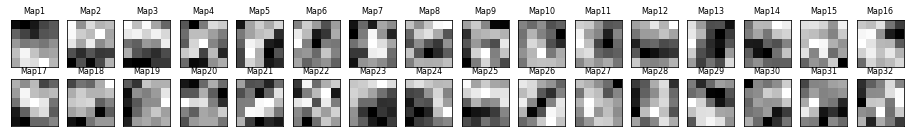

In [16]:
fig, axes = plt.subplots(2, 16, figsize=(16,2), subplot_kw={'xticks': [], 'yticks': []})
#fig.subplots_adjust(left=0.12, bottom=0.5, right=0.89, top=0.9, wspace=0.1, hspace=0.21)
axes = axes.flatten()
for i in range(len(axes)):
    axes[i].imshow(conv1_kernels[:,:,0,i], cmap='gray')
    axes[i].set_title('Map'+str(i+1), fontsize=8)
#plt.suptitle('Conv1 Kernels')
plt.show()
# imshow normalizes the kernel weights to between 0 and 1, then converts them to grayscale 0 to 255
# black is 0 and white is 255

# Difference of Gaussian.
* [Read](https://en.wikipedia.org/wiki/Gaussian_function#Two-dimensional_Gaussian_function)
* [Read](https://en.wikipedia.org/wiki/Difference_of_Gaussians)

[[ 0.06396 -0.01121 -0.07825 -0.10315 -0.07825 -0.01121  0.06396]
 [-0.01121 -0.1276  -0.1613  -0.1315  -0.1613  -0.1276  -0.01121]
 [-0.07825 -0.1613   0.1166   0.433    0.1166  -0.1613  -0.07825]
 [-0.10315 -0.1315   0.433    1.       0.433   -0.1315  -0.10315]
 [-0.07825 -0.1613   0.1166   0.433    0.1166  -0.1613  -0.07825]
 [-0.01121 -0.1276  -0.1613  -0.1315  -0.1613  -0.1276  -0.01121]
 [ 0.06396 -0.01121 -0.07825 -0.10315 -0.07825 -0.01121  0.06396]]

dog1.shape is (7, 7)


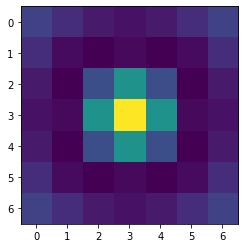

In [17]:
dog1 = fs.DoG(7, 1.0, 2.0)
print(dog1.astype(np.float16))
plt.imshow(dog1)
print("")
print('dog1.shape is {}'.format(dog1.shape))

[[-0.3965  0.0695  0.485   0.6396  0.485   0.0695 -0.3965]
 [ 0.0695  0.7905  1.      0.815   1.      0.7905  0.0695]
 [ 0.485   1.     -0.7227 -2.686  -0.7227  1.      0.485 ]
 [ 0.6396  0.815  -2.686  -6.2    -2.686   0.815   0.6396]
 [ 0.485   1.     -0.7227 -2.686  -0.7227  1.      0.485 ]
 [ 0.0695  0.7905  1.      0.815   1.      0.7905  0.0695]
 [-0.3965  0.0695  0.485   0.6396  0.485   0.0695 -0.3965]]

dog2.shape is (7, 7)


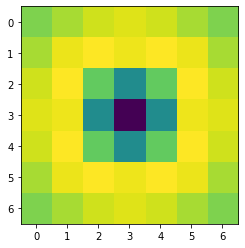

In [18]:
dog2 = fs.DoG(7, 2.0, 1.0)
print(dog2.astype(np.float16))
plt.imshow(dog2)
print("")
print('dog2.shape is {}'.format(dog2.shape))

## Setup the convolution in `tensorflow`

In [19]:
image_placeholder = tf.placeholder(tf.float32, shape=[1,28,28,1])
kernel_placeholder = tf.placeholder(tf.float32, shape=[7,7,1,1]) 
# 7x7 kernel with 1 input channels and 1 output channel/map
conv_strides_1d = [1, 1, 1, 1]
inter = tf.squeeze(tf.nn.conv2d(image_placeholder,kernel_placeholder,strides=conv_strides_1d,padding='VALID'))
sess= tf.Session()
init_op = tf.global_variables_initializer()
sess.run(init_op)

## Convolve with `DoG1` and Display

train_x[0,:,:,0].shape is (28, 28)


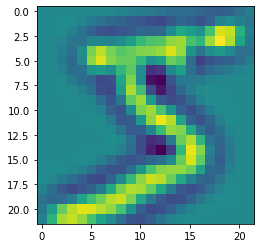

In [20]:
print('train_x[0,:,:,0].shape is {}'.format(train_x[0,:,:,0].shape))
image = train_x[0,:,:,0].reshape(1,28,28,1)
kernel = dog1.reshape(7,7,1,1)
result1 = sess.run(inter,feed_dict ={image_placeholder:image,kernel_placeholder:kernel})
plt.imshow(result1)

## Convolve with `DoG2` and Display

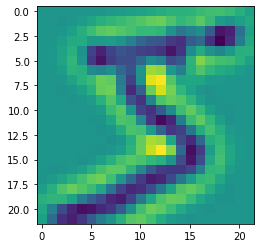

In [21]:
image = train_x[0,:,:,0].reshape(1,28,28,1)
kernel = dog2.reshape(7,7,1,1)
result2 = sess.run(inter,feed_dict ={image_placeholder:image,kernel_placeholder:kernel})
plt.imshow(result2)

# Restart the notebook to free up the `GPU` and `RAM`.

In [22]:
IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel

{'status': 'ok', 'restart': True}